In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

%matplotlib inline

C:\Users\kevin.wibowo\Miniconda3\envs\jcopml\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [2]:
df = pd.read_csv("data/titanic.csv", index_col="PassengerId")
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## First, let's take a look at the age distribution of Titanic Passengers

C:\Users\kevin.wibowo\Miniconda3\envs\jcopml\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\kevin.wibowo\Miniconda3\envs\jcopml\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([ 54.,  46., 177., 169., 118.,  70.,  45.,  24.,   9.,   2.]),
 array([ 0.42 ,  8.378, 16.336, 24.294, 32.252, 40.21 , 48.168, 56.126,
        64.084, 72.042, 80.   ]),
 <a list of 10 Patch objects>)

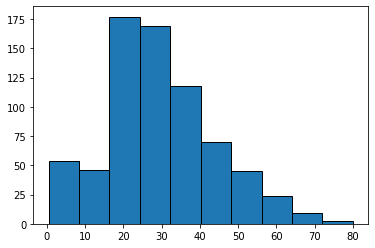

In [3]:
plt.figure()
plt.hist(df.Age, edgecolor='black')

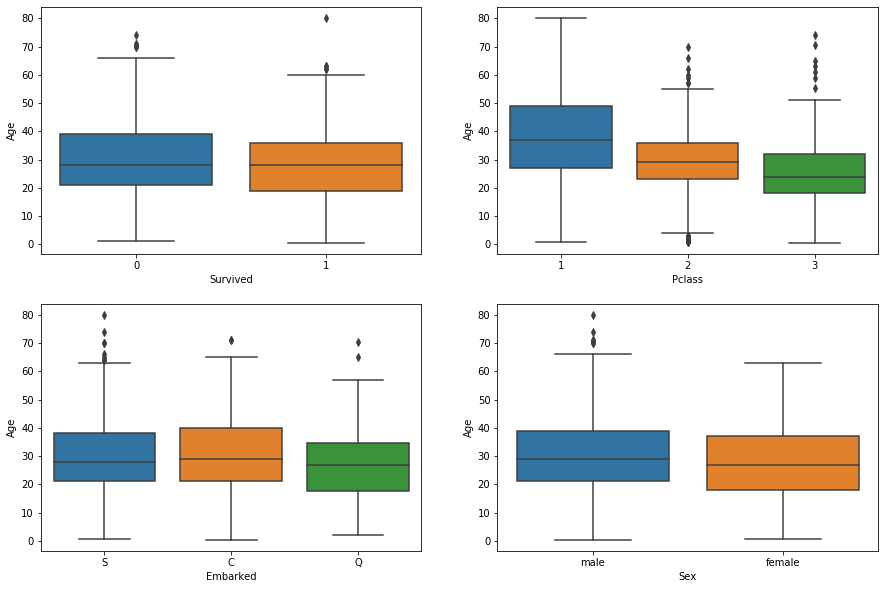

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(15,10))
sns.boxplot(x='Survived', y='Age', data=df, ax=axes[0, 0])
sns.boxplot(x='Pclass', y='Age', data=df, ax=axes[0, 1])
sns.boxplot(x='Embarked', y='Age', data=df, ax=axes[1, 0])
sns.boxplot(x='Sex', y='Age', data=df, ax=axes[1, 1])

In [5]:
df['age_cut'] = pd.cut(df['Age'], bins=[0, 5, 15, 25, 60, 90], labels=['infants', 'children', 'youngs', 'adults', 'elderly'])

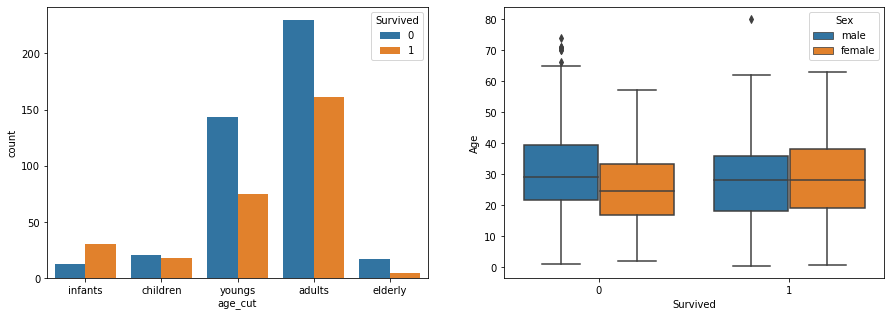

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
sns.countplot('age_cut', data=df, hue='Survived', ax=axes[0])
sns.boxplot(x='Survived', y='Age', data=df, hue='Sex', ax=axes[1])

The majority of Titanic Passengers are categorized as youngs and adults from 15 to 60 years old as we can see above. Their male passengers tends to be older than female, while the Pclass plot shows that higher class tends to be older people and have a wider range of age. We can't really take anything from embarked plot as they have distribution of data that almost the same between each location.


## Lets tackle this problem with simple method first

First, drop the column that need altering to be useful like Name, Ticket, and Cabin columns. Also the age_cut column that I used on Age EDA above.

In [7]:
df.drop(columns=['Name', 'Ticket', 'Cabin', 'age_cut'], inplace=True)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


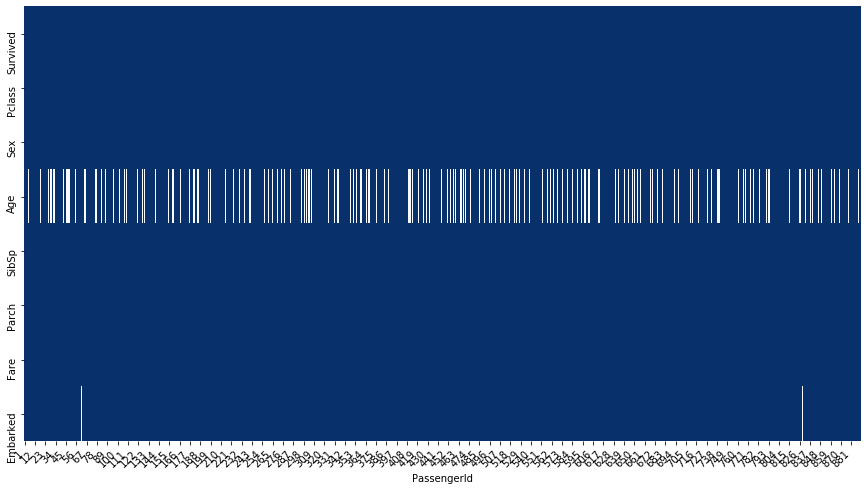

In [8]:
plot_missing_value(df)

In [9]:
X = df.drop(columns="Survived")
y = df.Survived

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((712, 7), (179, 7), (712,), (179,))

In [10]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 693 to 508
Data columns (total 7 columns):
Pclass      712 non-null int64
Sex         712 non-null object
Age         575 non-null float64
SibSp       712 non-null int64
Parch       712 non-null int64
Fare        712 non-null float64
Embarked    710 non-null object
dtypes: float64(2), int64(3), object(2)
memory usage: 44.5+ KB


In [11]:
for col in X_train.columns:
    print(col)

Pclass
Sex
Age
SibSp
Parch
Fare
Embarked


In [12]:
object_col = []
int_col = []

for col in X_train.columns:
    if X_train[col].dtype == 'O':
        object_col.append(col)
    else:
        int_col.append(col)
        
print(object_col, int_col, sep='\n')

['Sex', 'Embarked']
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


In [13]:
X_train.Parch.unique()

array([0, 1, 2, 5, 3, 4, 6], dtype=int64)

In [14]:
X_train.SibSp.unique()

array([0, 1, 8, 3, 4, 2, 5], dtype=int64)

If we see at the datatypes, the Pclass, SibSp, and Parch column included in integer column but they are instead categorical because the amount of data variation is not much and have a really low chance to change in the future. So we will move this column as categorical data. As conclusion, the numerical data will be ```['Age', 'Fare']``` and the categorical data will be ```['Sex', 'Embarked','Pclass', 'SibSp', 'Parch']```

### KNN

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

C:\Users\kevin.wibowo\Miniconda3\envs\jcopml\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
C:\Users\kevin.wibowo\Miniconda3\envs\jcopml\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [16]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ['Age', 'Fare']),
    ('categoric', cat_pipe(encoder='onehot'), ['Sex', 'Embarked', 'Pclass', 'SibSp', 'Parch']),
])

In [17]:
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', KNeighborsClassifier())
])

model = GridSearchCV(pipeline, gsp.knn_params, cv=5, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.0s


{'algo__n_neighbors': 3, 'algo__p': 1, 'algo__weights': 'uniform'}
0.8679775280898876 0.7683443317246134 0.7597765363128491


[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:    5.6s finished


### SVM

In [18]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

In [19]:
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVC(max_iter=500))
])

model = GridSearchCV(pipeline, gsp.svm_params, cv=5, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.7s


{'algo__C': 10.0, 'algo__gamma': 0.001}
0.8117977528089888 0.7795232936078007 0.7486033519553073


[Parallel(n_jobs=-1)]: Done 230 out of 245 | elapsed:    3.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 245 out of 245 | elapsed:    3.1s finished
C:\Users\kevin.wibowo\Miniconda3\envs\jcopml\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


### RF

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

In [21]:
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])

model = GridSearchCV(pipeline, gsp.rf_params, cv=5, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:   39.2s finished


{'algo__max_depth': 20, 'algo__max_features': 0.6, 'algo__min_samples_leaf': 5, 'algo__n_estimators': 100}
0.8876404494382022 0.8216980202895696 0.7821229050279329


### XGBoost

In [22]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

In [23]:
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBClassifier(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=5, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 235 out of 250 | elapsed:    3.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    3.7s finished


{'algo__colsample_bytree': 0.9763799669573133, 'algo__gamma': 3, 'algo__learning_rate': 0.05820013372709852, 'algo__max_depth': 4, 'algo__n_estimators': 163, 'algo__reg_alpha': 0.07362945281639222, 'algo__reg_lambda': 2.752717392942944, 'algo__subsample': 0.6401537692938899}
0.8497191011235955 0.8189205161036146 0.7821229050279329


### LogReg

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

In [25]:
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.logreg_params, cv=5, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.1s


{'algo__C': 5.132347525675527, 'algo__fit_intercept': False}
0.8202247191011236 0.8062641583768345 0.7988826815642458


[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    4.4s finished


The differences treatment for each model was on hyperparameters tuning. I was using gridsearch for KNN, RF, and SVM. While for XGBoost and LogReg I was using raondomized search. 
From the test above we can see that logreg has the best result on the test data and also this one is better than others because they are overfit with the train data. 

```
method /train_data /train_data_best /test_data
knn : 0.8679775280898876 /0.7683443317246134 /0.7597765363128491
svm : 0.8117977528089888 /0.7795232936078007 /0.7486033519553073
rf : 0.8876404494382022 /0.8216980202895696 /0.7821229050279329
xgb : 0.8497191011235955 /0.8189205161036146 /0.7821229050279329
logreg : 0.8202247191011236 /0.8062641583768345 /0.7988826815642458
```

So we will use the logistic regression method for this data.

```

take a note that transform yeo-johnson improve the model result a lot (like 2%) and will really help but we will get there later```

## After using the simple model, we can try to do feature engineering with the data to increase the model accuracy

### Age Binning

In [26]:
df = pd.read_csv("data/titanic.csv", index_col="PassengerId")
df['age_cut'] = pd.cut(df['Age'], bins=[0, 5, 15, 25, 60, 90], labels=['infants', 'children', 'youngs', 'adults', 'elderly'])
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,age_cut
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,youngs
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,adults
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,adults
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,adults
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,adults


### Parsing title from name

In [27]:
# Try parsing title from name columns
df['name_title'] = df.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip()) # strip default whitespace char

In [28]:
df.name_title.value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Major             2
Mlle              2
Col               2
Jonkheer          1
the Countess      1
Capt              1
Mme               1
Don               1
Sir               1
Ms                1
Lady              1
Name: name_title, dtype: int64

We can categorized the title name again to get another category like noble and trained with the purpose of simplify the categorical data in this column.

In [29]:
def update_title(title):
    if title in ['Col', 'Major', 'Capt']:
        return 'Trained'
    elif title in ['Don', 'Sir', 'Lady', 'the Countess', 'Jonkheer']:
        return 'Noble'
    elif title in ['Mme', 'Ms', 'Mlle', ]:
        return 'Miss'
    else:
        return title    

In [30]:
df.name_title = df.name_title.apply(update_title)
df.name_title.value_counts()

Mr         517
Miss       186
Mrs        125
Master      40
Dr           7
Rev          6
Noble        5
Trained      5
Name: name_title, dtype: int64

With this we can delete the name column because we only need name_title in the model.

After we do age binning and parsing title name we predict again to check if the feature engineering increasing our model accuracy or not

In [31]:
X = df.drop(columns="Survived")
y = df.Survived

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((712, 12), (179, 12), (712,), (179,))

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

In [33]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ['Fare']),
    ('categoric', cat_pipe(encoder='onehot'), ['Sex', 'Embarked', 'Pclass', 'SibSp', 'Parch', 'age_cut', 'name_title']),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.logreg_params, cv=5, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.1s


{'algo__C': 493.52962094021177, 'algo__fit_intercept': False}
0.8216292134831461 0.8146459174628188 0.7932960893854749


[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    4.6s finished


As we can see above, there is no improvement on the prediction result. So we can try another feature engineering which related ticket column.



## After getting the title from the name, we can continue with the ticket columns

In [34]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,age_cut,name_title
PassengerId,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,youngs,Mr
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,adults,Mrs
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,adults,Miss
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,adults,Mrs
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,adults,Mr


The data on Ticket column is messy so we going to split the data in this column to pure integer or mixed of integer and string.

In [35]:
df['num_ticket'] = df.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)
df['mix_ticket'] = df.Ticket.apply(lambda x: 0 if x.isnumeric() else 1)
df.head(2)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,age_cut,name_title,num_ticket,mix_ticket
PassengerId,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,youngs,Mr,0,1
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,adults,Mrs,0,1


In [36]:
X = df.drop(columns="Survived")
y = df.Survived

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((712, 14), (179, 14), (712,), (179,))

I will try 3 models with the best result from our simple model

### Logreg

In [37]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ['Fare']),
    ('categoric', cat_pipe(encoder='onehot'), ['Sex', 'Embarked', 'Pclass', 'SibSp', 'Parch', 'age_cut', 'name_title', 'num_ticket', 'mix_ticket']),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.logreg_params, cv=5, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 235 out of 250 | elapsed:    4.6s remaining:    0.2s


{'algo__C': 17.71884735480683, 'algo__fit_intercept': False}
0.827247191011236 0.8146656160740668 0.8044692737430168


[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    4.8s finished


In [75]:
# with transform yeo-johnson
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(transform='yeo-johnson'), ['Fare', 'Age']),
    ('categoric', cat_pipe(encoder='onehot'), ['Sex', 'Embarked', 'Pclass', 'SibSp', 'Parch', 'name_title', 'num_ticket', 'mix_ticket']),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.logreg_params, cv=5, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.3s


{'algo__C': 1.408146893930584, 'algo__fit_intercept': True}
0.8286516853932584 0.8202698709740963 0.8268156424581006


[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    5.1s finished


### RF

In [38]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ['Fare']),
    ('categoric', cat_pipe(encoder='onehot'), ['Sex', 'Embarked', 'Pclass', 'SibSp', 'Parch', 'age_cut', 'name_title', 'num_ticket', 'mix_ticket']),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])

model = GridSearchCV(pipeline, gsp.rf_params, cv=5, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:   41.4s finished


{'algo__max_depth': 20, 'algo__max_features': 0.8, 'algo__min_samples_leaf': 5, 'algo__n_estimators': 150}
0.8890449438202247 0.8174923667881414 0.7988826815642458


In [70]:
# with transform yeo-johnson
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(transform='yeo-johnson'), ['Fare', 'Age']),
    ('categoric', cat_pipe(encoder='onehot'), ['Sex', 'Embarked', 'Pclass', 'SibSp', 'Parch', 'name_title', 'num_ticket', 'mix_ticket']),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])

model = GridSearchCV(pipeline, gsp.rf_params, cv=5, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:   44.6s finished


{'algo__max_depth': 20, 'algo__max_features': 0.8, 'algo__min_samples_leaf': 5, 'algo__n_estimators': 100}
0.8932584269662921 0.823106470993795 0.8044692737430168


### XGBoost

In [50]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ['Fare']),
    ('categoric', cat_pipe(encoder='onehot'), ['Sex', 'Embarked', 'Pclass', 'SibSp', 'Parch', 'age_cut', 'name_title', 'num_ticket', 'mix_ticket']),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBClassifier(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=5, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.9s


{'algo__colsample_bytree': 0.6918516030703091, 'algo__gamma': 1, 'algo__learning_rate': 0.1216411342539395, 'algo__max_depth': 3, 'algo__n_estimators': 185, 'algo__reg_alpha': 0.011502956321912733, 'algo__reg_lambda': 0.009461469059966103, 'algo__subsample': 0.7865052773762229}
0.9087078651685393 0.8259430710134936 0.8156424581005587


[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    6.9s finished


In [64]:
# with transform yeo-johnson
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(transform='yeo-johnson'), ['Fare', 'Age']),
    ('categoric', cat_pipe(encoder='onehot'), ['Sex', 'Embarked', 'Pclass', 'SibSp', 'Parch', 'name_title', 'num_ticket', 'mix_ticket']),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBClassifier(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=5, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 235 out of 250 | elapsed:    4.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    4.4s finished


{'algo__colsample_bytree': 0.7431355937619569, 'algo__gamma': 3, 'algo__learning_rate': 0.38937887815945726, 'algo__max_depth': 3, 'algo__n_estimators': 191, 'algo__reg_alpha': 0.9466088751875813, 'algo__reg_lambda': 0.01007957241660779, 'algo__subsample': 0.392166837165685}
0.8778089887640449 0.8231458682162908 0.8212290502793296


## Try the submission on kaggle
Below this is to make the process easily shown in one cell, we will use the model from above for easier and cleaner notebook

In [68]:
df = pd.read_csv("data/titanic.csv", index_col="PassengerId")
df['age_cut'] = pd.cut(df['Age'], bins=[0, 5, 15, 25, 60, 90], labels=['infants', 'children', 'youngs', 'adults', 'elderly'])
df.head()

# Try parsing title from name columns
df['name_title'] = df.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip()) # strip default whitespace char

df.name_title = df.name_title.apply(update_title)
df.name_title.value_counts()

df['num_ticket'] = df.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)
df['mix_ticket'] = df.Ticket.apply(lambda x: 0 if x.isnumeric() else 1)

In [69]:
X = df.drop(columns="Survived")
y = df.Survived

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((712, 14), (179, 14), (712,), (179,))

## Test data

In [71]:
df_test = pd.read_csv("data/test.csv", index_col="PassengerId")

In [72]:
df_test['age_cut'] = pd.cut(df_test['Age'], bins=[0, 5, 15, 25, 60, 90], labels=['infants', 'children', 'youngs', 'adults', 'elderly'])

df_test['name_title'] = df_test.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip()) # strip default whitespace char
df_test.name_title = df_test.name_title.apply(update_title)

df_test['num_ticket'] = df_test.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)
df_test['mix_ticket'] = df_test.Ticket.apply(lambda x: 0 if x.isnumeric() else 1)

df_test.head(1)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,age_cut,name_title,num_ticket,mix_ticket
PassengerId,,,,,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,adults,Mr,1,0


In [74]:
sub_predict = pd.DataFrame(model.predict(df_test), columns=['Survived'], index=df_test.index)
sub_predict.to_csv('submission_rf_tranform.csv')

My first submission on kaggle for this topic was using the simple model and the second was using feature engineering above (age binning, parsing title on name column, and splitting the ticket column). <br>
__The best result that I got for now is 77.751% using Random Forest.__ <br>
I will try to improve my score using other feature engineering for this project.